In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from utils import tile_raster_images
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'

Instructions for updating:
Use the retry module or similar alternatives.


# Task 1

Implement the RBM that uses CD-1 for training. For input data use MNIST numbers. The visible layer must then have 784 elements, and the hidden layer should have 100 elements. Since the values of the input samples (image) are real numbers in the range [0 1], they can be used as $p(v_i=1)$, so for the initial values of the visible layer, sampling should be performed. Set the mini batch size to 100 samples, and the number of epochs to 100.

Subtasks:

1. Visualize the weights of $W$ obtained by training and try to interpret the weights associated with some hidden neurons.
2. Visualize the reconstruction results of the first 20 MNIST samples. Visualize the values of $p(v_i=1)=σ(∑^N_{j=1} w_{ji}h_j+a_i)$ instead of the binary values obtained by sampling.
3. Examine the activation frequency of hidden layer elements and visualize the learned weights of $W$ sorted by the frequency
4. Skip the initial sampling/binarization based on the real input data, and use the original input data (real numbers from the range [0 1]) as input layer $v$. How different is such RBM from the previous one?
5. Increase the number of Gibs sampling in CDs. What are the differences?
6. Examine the effects of varying the learning constant.
7. Randomly initialize the hidden layer, run a few Gibbs samplings, and visualize the generated visible layer
8. Perform above experiments with a smaller and a larger number of hidden neurons. What do you observe about weights and reconstructions?

Use the following template with the utility file [utils.py](https://dlunizg.github.io/assets/lab4/utils.py).

REMARK: In addition to filling out the missing code, the template should be tailored as needed, and can be customized freely. So please be especially careful with the claims that some of the code is not working for you!

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images,\
    mnist.test.labels

def weights(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias(shape):
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial)

def sample_prob(probs):
    """Sample vector x by probability vector p (x = 1) = probs"""
    return tf.to_float(tf.random_uniform(tf.shape(probs)) <= probs)

def draw_weights(W, shape, N, stat_shape, interpolation="bilinear"):
    """Visualization of weight
     W - weight vector
     shape - tuple dimensions for 2D weight display - usually input image dimensions, eg (28,28)
     N - number weight vectors
     shape_state - Dimension for 2D state display (eg for 100 states (10,10)
    """
    image = (tile_raster_images(
        X=W.T,
        img_shape=shape,
        tile_shape=(int(math.ceil(N/stat_shape[0])), stat_shape[0]),
        tile_spacing=(1, 1)))
    plt.figure(figsize=(10, 14))
    plt.imshow(image, interpolation=interpolation)
    plt.axis('off')
    
def draw_reconstructions(ins, outs, states, shape_in, shape_state, N):
    """Visualization of inputs and associated reconstructions and hidden layer states
     ins -- input vectors
     outs - reconstructed vectors
     states - hidden layer state vectors
     shape_in - dimension of input images eg (28,28)
     shape_state - Dimension for 2D state display (eg for 100 states (10,10)
     N - number of samples
    """
    plt.figure(figsize=(8, int(2 * N)))
    for i in range(N):
        plt.subplot(N, 4, 4*i + 1)
        plt.imshow(ins[i].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Test input")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 2)
        plt.imshow(outs[i][0:784].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Reconstruction")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 3)
        plt.imshow(states[i].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("States")
        plt.axis('off')
    plt.tight_layout()

def draw_generated(stin, stout, gen, shape_gen, shape_state, N):
    """Visualization of initial hidden states, final hidden states and associated reconstructions
     stin - the initial hidden layer
     stout - reconstructed vectors
     gen - vector of hidden layer state
     shape_gen - dimensional input image eg (28,28)
     shape_state - Dimension for 2D state display (eg for 100 states (10,10)
     N - number of samples
    """
    plt.figure(figsize=(8, int(2 * N)))
    for i in range(N):

        plt.subplot(N, 4, 4*i + 1)
        plt.imshow(stin[i].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("set state")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 2)
        plt.imshow(stout[i][0:784].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("final state")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 3)
        plt.imshow(gen[i].reshape(shape_gen), vmin=0, vmax=1, interpolation="nearest")
        plt.title("generated visible")
        plt.axis('off')
    plt.tight_layout()


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
def get_w1_grad(v, h):    
    v = tf.reshape(v, [-1, int(v.shape[1]), 1])
    h = tf.reshape(h, [-1, 1, int(h.shape[1])])
    return tf.reduce_sum(tf.matmul(v, h), reduction_indices=0) 

In [4]:

Nh = 100 # The number of elements of the first hidden layer
h1_shape = (10,10)
Nv = 784 # The number of elements of the first hidden layerBroj elemenata vidljivog sloja
v_shape = (28,28)
Nu = 5000 # Number of samples for visualization of reconstruction

gibbs_sampling_steps = 1
alpha = 0.1

g1 = tf.Graph()
with g1.as_default():
        
    X1 = tf.placeholder("float", [None, 784])
    w1 = weights([Nv, Nh])
    vb1 = bias([Nv]) # a_i - bias for visible layer
    hb1 = bias([Nh]) # b_i - bias for hidden layer
    
    h0_prob = tf.sigmoid(tf.matmul(X1, w1) + tf.transpose(hb1))
    h0 = sample_prob(h0_prob)
    h1 = h0

    for step in range(gibbs_sampling_steps):
        v1_prob = tf.sigmoid(tf.matmul(h1, tf.transpose(w1)) + tf.transpose(vb1))
        v1 = sample_prob(v1_prob)
        h1_prob = tf.sigmoid(tf.matmul(v1, w1) + tf.transpose(hb1))
        h1 = sample_prob(h1_prob)
        
    
    w1_positive_grad = get_w1_grad(X1, h0_prob)
    w1_negative_grad = get_w1_grad(v1_prob, h1_prob)
    '''
    w1_positive_grad = get_w1_grad(X1, h0_prob)

            # negativna faza
            w1_negative_grad = get_w1_grad(v1_prob, h1_prob) 
             # pozitivna faza
            w1_positive_grad = get_w1_grad(X1, h0_prob)

            # negativna faza
            w1_negative_grad = get_w1_grad(v1_prob, h1_prob)    
            
            def get_w1_grad(v, h):    
                v = tf.reshape(v, [-1, int(v.shape[1]), 1])
                h = tf.reshape(h, [-1, 1, int(h.shape[1])])
                return tf.reduce_sum(tf.batch_matmul(v, h), reduction_indices=0) 
    '''

    dw1 = (w1_positive_grad - w1_negative_grad) / tf.to_float(tf.shape(X1)[0]) # .shape[0] - number of rows

    update_w1 = tf.assign_add(w1, alpha * dw1)
    update_vb1 = tf.assign_add(vb1, alpha * tf.reduce_mean(X1 - v1, 0))
    update_hb1 = tf.assign_add(hb1, alpha * tf.reduce_mean(h0 - h1, 0)) 

    out1 = (update_w1, update_vb1, update_hb1)
    
    #v1_prob = # calculated before, in the loop
    #v1 = # not used anywhere later
    
    err1 = X1 - v1_prob
    err_sum1 = tf.reduce_mean(err1 * err1)
    
    initialize1 = tf.global_variables_initializer()

batch_size = 100
epochs = 100
n_samples = mnist.train.num_examples
total_batch = int(n_samples / batch_size) * epochs

sess1 = tf.Session(graph=g1)
sess1.run(initialize1)


In [5]:
print('total batch:', total_batch)
total_batch = int(total_batch/55)
print('total batch:', total_batch)


total batch: 55000
total batch: 1000


In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def draw_rec(inp, title, size, Nrows, in_a_row, j):
    """ Draw an iteration of creating the visible layer
     inp - visible layer
     title - thumbnail title
     size - 2D dimensions of visible layer
     Nrows - max. number of thumbnail rows 
     in-a-row. number of thumbnails in one row
     j - position of thumbnails in the grid
    """
    plt.subplot(Nrows, in_a_row, j)
    plt.imshow(inp.reshape(size), vmin=0, vmax=1, interpolation="nearest")
    plt.title(title)
    plt.axis('off')
    
    
def reconstruct(ind, states, orig, weights, biases):
    """ Sequential visualization of  the visible layer reconstruction
     ind - index of digits in orig (matrix with digits as lines)
     states - state vectors of input vectors
     orig - original input vectors
     weights - weight matrix
    """
    j = 1
    in_a_row = 6
    Nimg = states.shape[1] + 3
    Nrows = int(np.ceil(float(Nimg+2)/in_a_row))
    
    plt.figure(figsize=(12, 2*Nrows))
       
    draw_rec(states[ind], 'states', h1_shape, Nrows, in_a_row, j)
    j += 1
    draw_rec(orig[ind], 'input', v_shape, Nrows, in_a_row, j)
    
    reconstr = biases.copy()
    j += 1
    draw_rec(sigmoid(reconstr), 'biases', v_shape, Nrows, in_a_row, j)
    
    for i in range(Nh):
        if states[ind,i] > 0:
            j += 1
            reconstr = reconstr + weights[:,i]
            titl = '+= s' + str(i+1)
            draw_rec(sigmoid(reconstr), titl, v_shape, Nrows, in_a_row, j)
    plt.tight_layout()
    

In [7]:
print('Run session')
for i in range(total_batch):
    batch, label = mnist.train.next_batch(batch_size)
    err, _ = sess1.run([err_sum1, out1], feed_dict={X1: batch})
        
    if i%(int(total_batch/10)) == 0:
        print(i, err)

w1s = w1.eval(session=sess1)
vb1s = vb1.eval(session=sess1)
hb1s = hb1.eval(session=sess1)
vr, h1s = sess1.run([v1_prob, h1], feed_dict={X1: teX[0:Nu,:]})


Run session
0 0.24844113
100 0.03696029
200 0.031528614
300 0.028735438
400 0.027210899
500 0.025644528
600 0.02590261
700 0.022923904
800 0.026911678
900 0.023661952


Subtask 1
visualization of weights


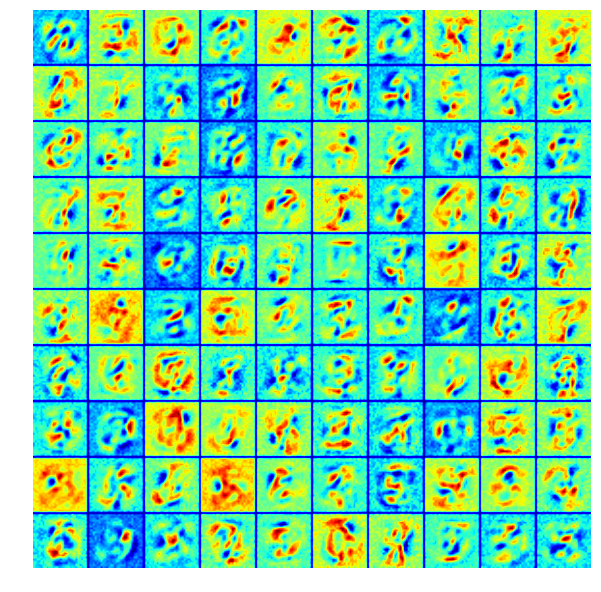

In [8]:
print('Subtask 1')
print('visualization of weights')
# visualization of weights
draw_weights(w1s, v_shape, Nh, h1_shape)


Subtask 2
visualization of reconstructions of 20 MNIST samples


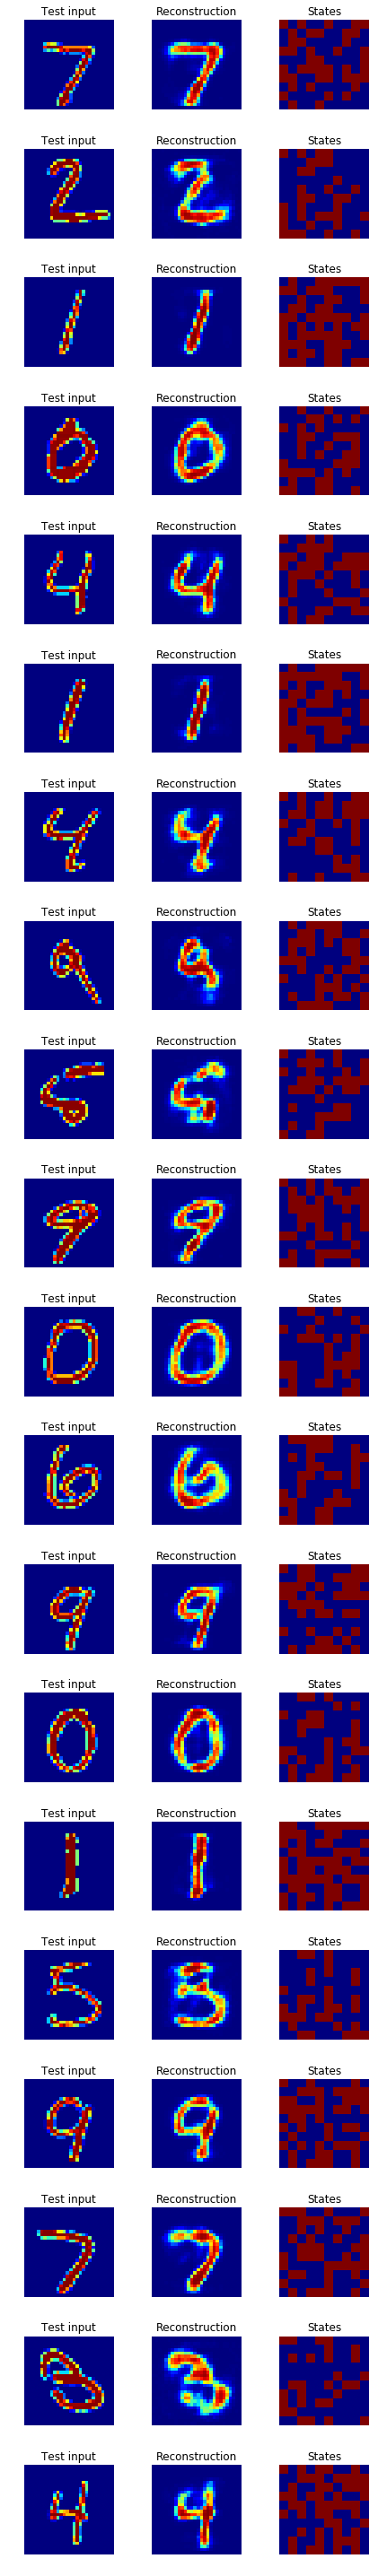

In [9]:
print('Subtask 2')
print('visualization of reconstructions of 20 MNIST samples')
# visualization of reconstructions and states
draw_reconstructions(teX, vr, h1s, v_shape, h1_shape, 20)


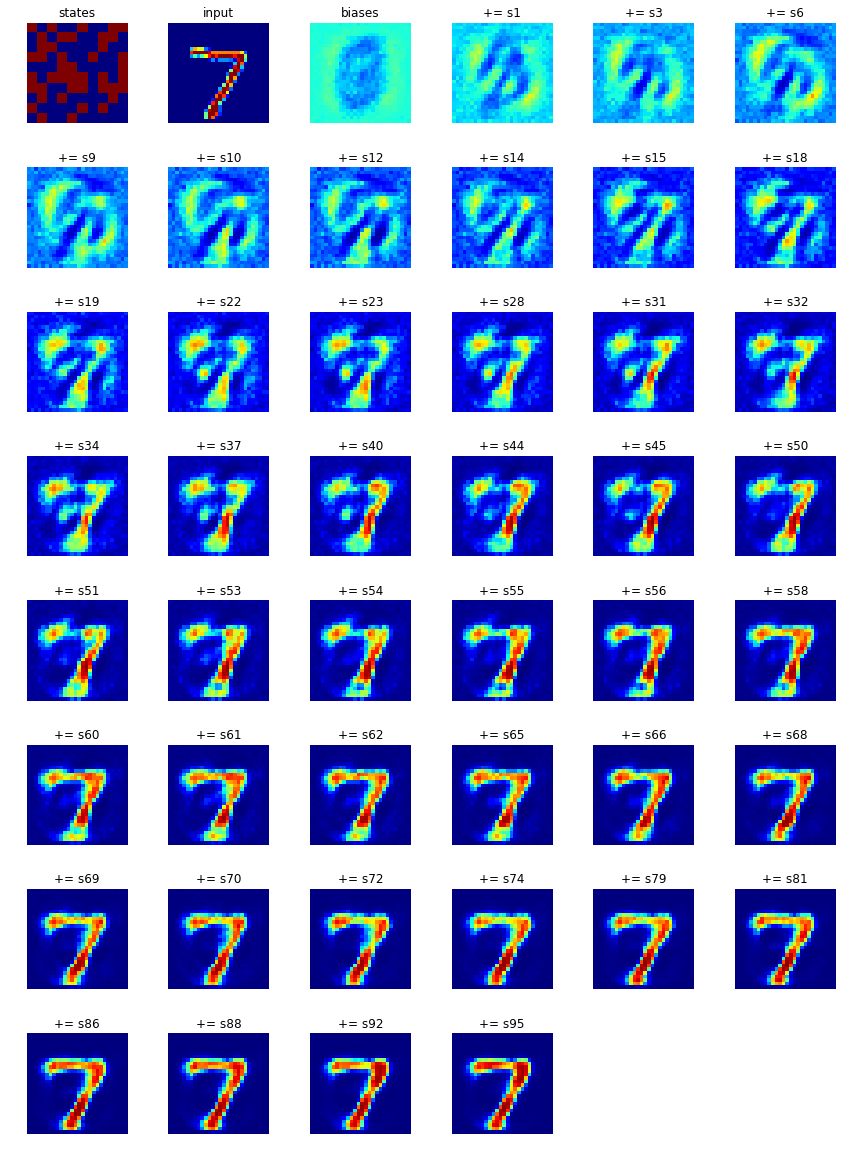

In [10]:
# visualization of a reconstructions with the gradual addition of the contributions of active hidden elements
reconstruct(0, h1s, teX, w1s, vb1s) # the first argument is the digit index in the digit matrix


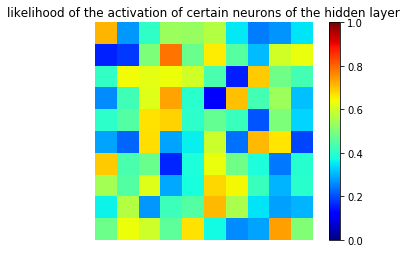

In [11]:
# The probability that the hidden state is included through Nu input samples
'''
plt.figure()
tmp = (h1s.sum(0)/h1s.shape[0]).reshape(h1_shape)
plt.imshow(tmp, vmin=0, vmax=1, interpolation="nearest")
plt.axis('off')
plt.colorbar()
plt.title('likelihood of the activation of certain neurons of the hidden layer')
'''


Subtask 3
Visualization of weights sorted by frequency


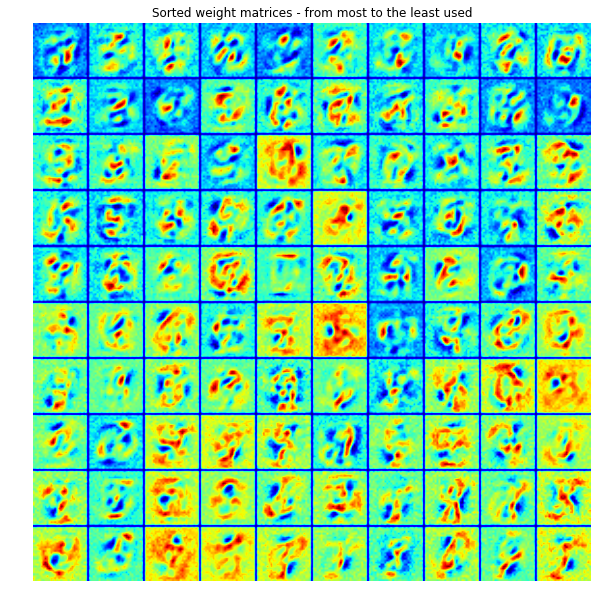

In [12]:
print('Subtask 3')
print('Visualization of weights sorted by frequency')
# Visualization of weights sorted by frequency
tmp = (h1s.sum(0)/h1s.shape[0]).reshape(h1_shape)
tmp_ind = (-tmp).argsort(None)
draw_weights(w1s[:, tmp_ind], v_shape, Nh, h1_shape)
plt.title('Sorted weight matrices - from most to the least used')


In [13]:
print('Subtask 4')
print('Generating samples from random vectors')
# Generating samples from random vectors
r_input = np.random.rand(100, Nh)
r_input[r_input > 0.9] = 1 # percentage of active - vary freely
r_input[r_input < 1] = 0
r_input = r_input * 20 # Boosting in case a small percentage is active

s = 10
for i in range(10):
    r_input[i,:] = 0
    r_input[i,i]= s

#out_1_prob, out_1, hout1 = sess1.run((v1_prob, v1, h1), feed_dict={h0: r_input})
out_1 = sess1.run((v1), feed_dict={h0: r_input})


Subtask 4
Generating samples from random vectors


In [ ]:
draw_generated(r_input, hout1, out_1_prob, v_shape, h1_shape, 10)


Subtask 5
Emulation of additional Gibbs sampling using feed_dict
0
100
200
300
400
500
600
700
800
900


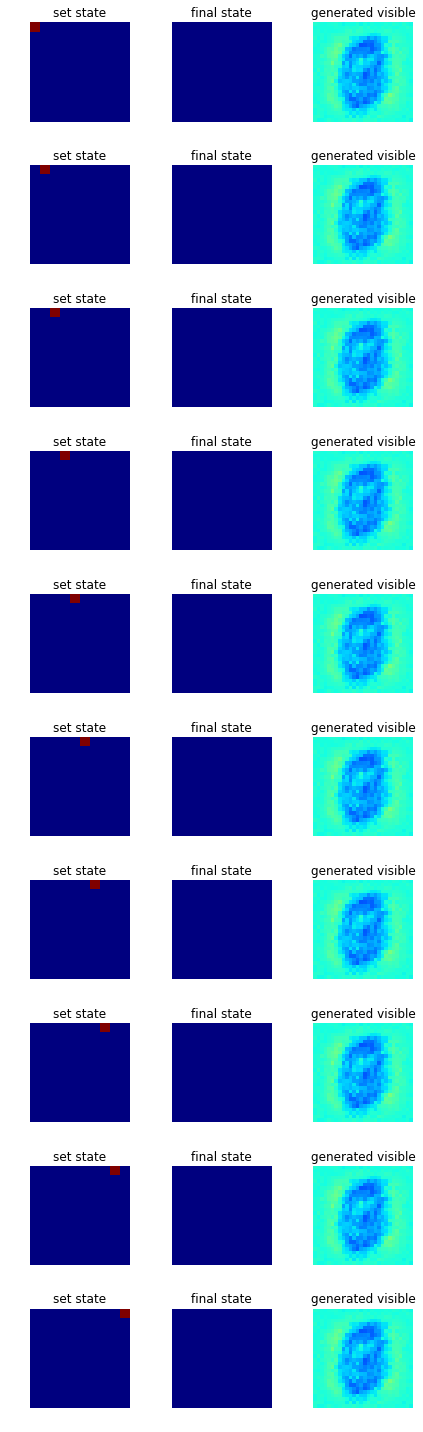

In [16]:
print('Subtask 5')
print('Emulation of additional Gibbs sampling using feed_dict')
# Emulation of additional Gibbs sampling using feed_dict
for i in range(1000):
    out_1_prob, out_1, hout1 = sess1.run((v1_prob, v1, h1), feed_dict={X1: out_1})
    if i%100 == 0:
        print(i)

draw_generated(r_input, hout1, out_1_prob, v_shape, h1_shape, 10)